In [35]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt

In [36]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.2
sim.parameters["n_variants"] = 15

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
sim.parameters["x_e_std"] = 1
sim.parameters["y_e_std"] = 1

In [37]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
    0.05,
    0.5 - 0.05,
    size=sim.get_sim_parameter("n_variants")
)
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    sim.add_variable(variant)

# We simulate variant effects.
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        effect = variant_effects[i]
        
        x += effect * variant
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(0, scale=sim.parameters["x_e_std"], size=sim.n)
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

In [38]:
sim.save(0)
sim.resample()
sim.save(1)

In [39]:
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,-1.155038,0,0,0,0,1,1,0,0,0,0,0,0,1,1,2,0.886202,-0.626339
1,1.271396,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1.288299,-0.685280
2,0.079011,2,1,0,0,1,0,0,0,1,0,1,1,1,1,0,-0.254206,-0.446126
3,-0.312225,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,-1.278092,0.554149
4,1.372970,0,0,2,0,1,2,1,0,2,1,2,0,0,1,0,0.600679,0.318544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.029920,1,0,0,1,0,1,0,1,0,0,2,1,0,1,0,0.971610,0.959147
99996,0.844415,0,0,2,0,0,0,0,0,0,0,0,0,1,2,0,1.543400,-1.392684
99997,-1.773345,1,1,2,1,0,0,0,0,2,1,2,0,0,1,0,-0.898802,-0.413168
99998,0.828417,0,1,2,1,0,1,0,0,0,0,0,0,0,0,0,2.152888,1.194905


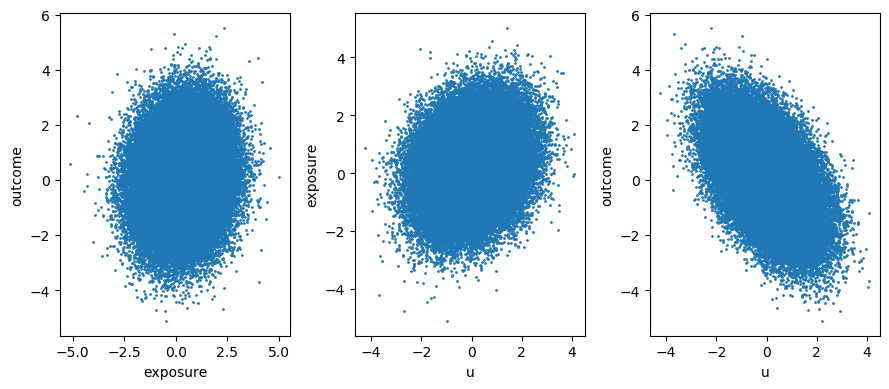

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()